# Introduction

The following notebook trains an agent that uses a combination of reinforcement learning (q-learning) and working memory. The two modules are implemented separately and their predictions are combined to decide the final decision to take. In this case, the working memory module implemented mimics the human working memory as it has limited capacity and also the value of items present in the WM become more and more uncertain as the time that has elapsed since the values were stored increases.

In [68]:
#Import libraries
import gym
from gym import error, spaces, utils
import numpy as np
import math
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib
from collections import namedtuple, deque
from tqdm import tqdm, trange
from blocks import EnvClass

In [69]:
#Choosing action based on final RL policy and the working memory module along with randomness decided by a parameter epsilon
#If the action taken is not random, then a probability with respect to each action is calculated from the Q-function
#for the given state variable as well as a probability for each action from the working memory module.
#A weighted sum of the two probabilities is taken and the action with the highest final score is chosen.

def actionSelect(curr_state, curr_r, curr_q, eps,last_returned_reward, last_visit_time, replenishing_rate,time, weight_for_replenishing_rate):
        
        # print(weight_for_replenishing_rate)
        #Adding forgetful working memory... Noise added to stored value by drawing sample for normal distribution with 
        #mean 0 and std directly proportional to the time after which the stored value has been accessed
        sampled_replenishing_rate = np.random.normal(replenishing_rate, (time-last_visit_time)/5000)
        for i in range(8):
            if(sampled_replenishing_rate[i]<0):
                sampled_replenishing_rate[i] = 0
        if(np.random.uniform(0,1) < eps):
            action = np.random.choice(np.arange(8))
        else:
            estimated_value = last_returned_reward + (time-last_visit_time)*(sampled_replenishing_rate) +1e-6
            estimated_prob = estimated_value/(np.sum(estimated_value))
            
            if(np.all(curr_q[curr_state][curr_r] == np.zeros(8))):
                action = np.random.choice(np.arange(8), p =estimated_prob.tolist())
            else:
                q_prob = np.exp(curr_q[curr_state][curr_r])/(np.sum(np.exp(curr_q[curr_state][curr_r])))
                # action = np.random.choice(np.arange(8), p =((estimated_prob*weight_for_replenishing_rate)+(q_prob*(1-weight_for_replenishing_rate))))
                action = np.argmax((estimated_prob*weight_for_replenishing_rate)+(q_prob*(1-weight_for_replenishing_rate)))
        
        return(action)


In [70]:


def playEnv(env,curr_q, replenishing_rate, weight_for_replenishing_rate):
    
    env.reset()
    done = False
    curr_state = 8
    cur_reward = 0
    r =0
    last_returned_reward = np.zeros(8)
    last_visit_time = np.zeros(8)
    time =0
    while not done:
        sampled_replenishing_rate = np.random.normal(replenishing_rate, (time-last_visit_time)/5000)
        estimated_value = last_returned_reward + (time-last_visit_time)*(sampled_replenishing_rate) +1e-6
        estimated_prob = estimated_value/(np.sum(estimated_value))
        q_prob = np.exp(curr_q[curr_state][r])/(np.sum(np.exp(curr_q[curr_state][r])))
        a = np.argmax((estimated_prob*weight_for_replenishing_rate)+(q_prob*(1-weight_for_replenishing_rate)))
        (s_new, r, done, _) = env.step(a)
        time = 300-s_new[1]
        cur_reward += r        
        
        if(r!=0):
            last_visit_time[s_new[0]] = time
            last_returned_reward[s_new[0]] = r
        
        curr_state = s_new[0]
        
    return cur_reward

#Function to decay parameter from finalValue -> initialValue starting from startStep step and upto maxSteps using
#the decayType characteristic

def decayParameter(initialValue, finalValue, startStep, maxSteps, decayType):
    arr = [initialValue]
    para = initialValue
    step = 0
    
    if(decayType == 'linear'):
        rate = (initialValue-finalValue)/(maxSteps-startStep)
    else:
        rate = np.power(finalValue/initialValue, 1/(maxSteps-startStep))
    
    while(step < maxSteps):
        step += 1
        
        if(step>startStep):
            if(decayType=='linear'):
                para -= rate
            else:
                para *= rate
        arr.append(para)
        
    return(arr)

#Returns the greedy policy from the given state-action value function

def GreedyPolicy(Q):
    
    pi = np.zeros((Q.shape[0],Q.shape[1]))
    
    for s in range(Q.shape[0]):
        
        for r in range(Q.shape[1]):
            
            q = Q[s][r]
            a = np.argmax(q)

            pi[s][r] = int(a)
        
    return pi


# Update WM memory with limited capacity constraint, i.e. forget the info about states other than the last 3 
#visited states
def updateRecentStates(last_three_states, newState, replenishing_rate, last_returned_reward, last_visit_time):
    replenishing_rate[0] = 0
    last_returned_reward[0] = 0
    last_visit_time[0] = 0
    last_three_states[0] = last_three_states[1]
    last_three_states[1] = last_three_states[2]
    last_three_states[2] = newState
    return last_three_states, replenishing_rate, last_returned_reward, last_visit_time

In [71]:
#Function to train the Q-learning agent
#takes as input various hyperparameters like gamma, no of episodes to train for as well as the 
#parameters for decaying alpha and epsilon parameters
#Env to train the agent on also has to be given as input

def q_learning(env, gamma, alpha, epsilon, noEpisodes, replenishing_rate_weight_start, replenishing_rate_weight_end):
    curr_q = np.zeros((9,201,8))
    total_rewards = []
    policy_reward = []

    al,e = alpha[3], epsilon[3]
    
    alpha = decayParameter(*alpha)
    epsilon = decayParameter(*epsilon)
    #Weight for wm module in action select
    weight_for_replenishing_rate = decayParameter(replenishing_rate_weight_start, replenishing_rate_weight_end, 0, noEpisodes, 'linear')
    
    replenishing_rate = np.zeros(8)
    
    for i in trange(noEpisodes):
        last_returned_reward = np.zeros(8)
        last_visit_time = np.zeros(8)
        curr_state = env.present_state
        curr_r = 0
        done = False
        played_reward = playEnv(env,curr_q, replenishing_rate, weight_for_replenishing_rate[i])
        policy_reward.append(played_reward)
        env.reset()
        

        total_r = 0
        time =0
        flag =0
        last_three_states = np.zeros(8)
        while(not done):
            a = actionSelect(curr_state, curr_r, curr_q, epsilon[int(min(i, e-1))], last_returned_reward, last_visit_time, replenishing_rate, time, weight_for_replenishing_rate[i])

            (s_new, r, done, _) = env.step(a)
            time = 300-s_new[1]

            last_three_states, replenishing_rate, last_returned_reward, last_visit_time = updateRecentStates(last_three_states, s_new[0], replenishing_rate, last_returned_reward, last_visit_time)
            
            if(flag):
                if(s_new[0]== curr_state):
                    
                    if(r > last_returned_reward[s_new[0]] and last_visit_time[curr_state]!=0):
                        temp = 0.6*replenishing_rate[s_new[0]] + 0.4*(max(r-last_returned_reward[s_new[0]], 0)/(time - last_visit_time[s_new[0]]))
                        replenishing_rate[s_new[0]] = temp
                    last_visit_time[curr_state] = time

                flag =0

            if(time - last_visit_time[s_new[0]]>1):
                flag = 1

            if(flag ==0):
#                 print('hello')
                last_visit_time[s_new[0]] = time
                last_returned_reward[s_new[0]] = r
            
            total_r += r
            
            td_target = r
            if(not done):
                td_target += gamma*np.max(curr_q[int(s_new[0])][int(r)])
                
            td_error = td_target - curr_q[curr_state][curr_r][a]
            
#             print(curr_state, a, i)
            curr_q[curr_state][curr_r][a] += alpha[int(min(i, al-1))]*td_error
            
            curr_state = s_new[0]
            curr_r = int(r)
        
#         print(total_r)
        total_rewards.append(total_r)
        
    return curr_q, total_rewards, replenishing_rate, policy_reward

# Training Agent and Experimentation

In [81]:
gamma = 0.4
alpha = 0.05
epsilon = 1
noEpisodes = 1000

envs = EnvClass()
env = envs.getBlock(3)

Q_s  = np.zeros((5, 9, 201, 8))
rewards = np.zeros((5, noEpisodes))
policy_rewards = np.zeros((5, noEpisodes))
replenishing_rates = np.zeros((5,8))

replenishing_rate_weight_start=1
replenishing_rate_weight_end =1

for i in range(5):
    np.random.seed(i+80)
    env.reset()

    Q, reward, replenishing_rate, policy_reward = q_learning(env, gamma, (alpha, 0.01, 0, noEpisodes//2, 'exponential'), (epsilon, 0.01, 0, (9*noEpisodes)//10, 'linear'), noEpisodes, replenishing_rate_weight_start, replenishing_rate_weight_end)
    # print(reward)
    Q_s[i] = Q
    rewards[i] = reward
    policy_rewards[i] = policy_reward
    replenishing_rates[i] = replenishing_rate

replenishing_rate = np.mean(replenishing_rates, axis =0)
Q = np.mean(Q_s, axis=0)
p = GreedyPolicy(Q)


100%|██████████| 1000/1000 [00:37<00:00, 26.41it/s]


In [84]:
np.savez("data/gredy_rewards_limited_memory_with_decay.npz", np.mean(policy_rewards,axis =0))

18784


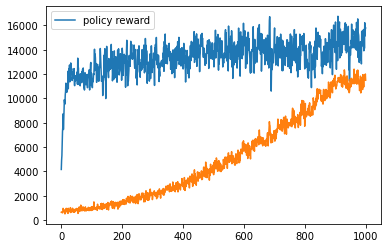

In [73]:
print(playEnv(env, Q, replenishing_rate, 0.5))
# print(reward[90:])
plt.plot(np.mean(policy_rewards,axis =0), label = "policy reward")
plt.plot(np.mean(rewards,axis=0))
# plt.plot(reward)
plt.legend()